## Video and Audio Content Analysis with Amazon Bedrock and Amazon Aurora PostgreSQL pgvector

This notebook demonstrates how to process video and audio content using [Amazon Bedrock](https://aws.amazon.com/bedrock/) to invoke [Amazon Titan Multimodal Embeddings G1 model](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html) for generating multimodal embeddings, [Amazon Transcribe](https://aws.amazon.com/transcribe/) for converting speech to text, and [Amazon Aurora PostgreSQL](https://docs.aws.amazon.com/AmazonRDS/latest/AuroraUserGuide/data-api.html) with pgvector for efficient vector storage and similarity search, you will build an app that understands both visual and audio content, enabling natural language queries to find specific moments in videos.

> Create Amazon Aurora PostgreSQL with this [Amazon CDK Stack](https://github.com/build-on-aws/langchain-embeddings/tree/main/create-aurora-pgvector)

![Diagram](data/video-embedding.png)


### Processing Flow

The pipeline processes videos through these steps:

1. A video file is processed using Python code in a Jupyter notebook, utilizing the boto3 SDK to interact with AWS services.

2. The audio stream is extracted and sent to Amazon Transcribe for speech-to-text conversion.

3. Simultaneously, the video is processed to extract key frames, which are stored in an Amazon S3 bucket.

4. The extracted frames are processed through Amazon Bedrock's Titan embedding model to generate multimodal vectors that represent the visual content.

5. Finally, all the processed data (transcriptions, frame data, and vectors) is stored in Amazon Aurora Serverless PostgreSQL with pgvector extension, enabling vector-based searches through standard RDS API calls.

![Diagram](data/diagram_video.png)

### 💰 Cost to complete: 
- [Amazon Bedrock Pricing](https://aws.amazon.com/bedrock/pricing/)
- [Amazon S3 Pricing](https://aws.amazon.com/s3/pricing/)
- [Amazon Aurora Pricing](https://aws.amazon.com/rds/aurora/pricing/)
- [Amazon Transcribe Pricing](https://aws.amazon.com/transcribe/pricing/)

### Configuration
- [AWS SDK for Python ](https://docs.aws.amazon.com/AmazonS3/latest/userguide/UsingTheBotoAPI.html)
- [Configure AWS credentials](https://docs.aws.amazon.com/braket/latest/developerguide/braket-using-boto3.html) 



In [ ]:
#!pip install boto3
#!pip install json
#!pip install base64
#!pip install uuid
# or install requirements.txt

In [ ]:
!brew install ffmpeg

In [1]:
import boto3
import json
import os
from PIL import Image as PILImage
import random

_region_name = "us-east-1"
ssm = boto3.client(service_name="ssm", region_name=_region_name)

# Default model settings
default_model_id = os.environ.get("DEFAULT_MODEL_ID", "amazon.titan-embed-image-v1")
default_embedding_dimmesion = os.environ.get("DEFAULT_EMBEDDING_DIMENSION", "1024")

## 2. Database Interface (AuroraPostgres Class)

An `AuroraPostgres` class that interacts with Amazon Aurora PostgreSQL [using RDS Data API](https://docs.aws.amazon.com/AmazonRDS/latest/AuroraUserGuide/data-api.html)

Code: [aurora_service.py](create_audio_video_helper/aurora_service.py)

In [2]:
from create_audio_video_helper import AuroraPostgres

## 3. Video Content Processing

A `VideoProcessor` class uses the [ffmpeg libavcodec library](https://ffmpeg.org/) to proccess the audio and create frames. 

The class is set to process frames every 1 second, you can modify this by changing the FPS value in command.

Code: [video_processor.py](create_audio_video_helper/video_processor.py)

In [3]:
from create_audio_video_helper import VideoProcessor

## 4. Video Download and Processing

Code: [video_manager.py](create_audio_video_helper/video_manager.py)

In [4]:
from create_audio_video_helper import VideoManager


## 5. Audio Processing with Amazon Transcribe

The `AudioProcessing` class extracts the audio track from the video file using [Amazon Transcribe StartTranscriptionJob API](https://docs.aws.amazon.com/transcribe/latest/APIReference/API_StartTranscriptionJob.html), converting speech into accurate text transcripts.
With `IdentifyMultipleLanguages` as True, Transcribe uses [Amazon Comprehend](https://aws.amazon.com/comprehend/)to identify the language in the audio, If you know the language of your media file, specify it using the `LanguageCode` parameter.  

`ShowSpeakerLabels` parameter as `True` enables speaker partitioning (diarization) in the transcription output. Speaker partitioning labels the speech from individual speakers in the media file and include `MaxSpeakerLabels` to specify the maximum number of speakers, in this case is 10. 

Code: [audio_processor.py](create_audio_video_helper/audio_processing.py)

In [5]:
from create_audio_video_helper import AudioProcessing

## 6. Embedding Generation

Generate Embeddings for each extracted frame. Embeddins are created with the Amazon Titan Multimodal Embeddings G1 model using Amazon Bedrock Invoke Model API. 

Code: [embedding_generation.py](create_audio_video_helper/embedding_generation.py)


In [6]:
from create_audio_video_helper import EmbeddingGeneration

## 7. Select Key Frames

The app uses the `CompareFrame` class to identifies significant visual changes by detecting when frame similarity falls below a defined threshold, in this case 0.8. This comparison leverages Cosine Similarity, calculating the cosine of the angle between frame vectors. The similarity score ranges from -1 to 1, with higher values indicating greater visual similarity between frames.

Code: [compare_frames.py](create_audio_video_helper/compare_frames.py)


In [7]:
from create_audio_video_helper import CompareFrames

### Configuration
The system uses environment variables and AWS Systems Manager Parameter Store for configuration:

**DEFAULT_MODEL_ID:** Bedrock model ID (default: "amazon.titan-embed-image-v1")

**DEFAULT_EMBEDDING_DIMENSION:** Embedding dimension (default: "1024")

In [8]:

def get_ssm_parameter(name):
    response = ssm.get_parameter(Name=name, WithDecryption=True)
    return response["Parameter"]["Value"]



In [11]:
# Get Data from environment variables, never share secrets!

cluster_arn = get_ssm_parameter("/videopgvector/cluster_arn")
credentials_arn = get_ssm_parameter("/videopgvector/secret_arn")
#table_name = get_ssm_parameter("/videopgvector/table_name")
default_database_name = "kbdata"


In [12]:
# Initialize Aurora PostgreSQL client
aurora = AuroraPostgres(cluster_arn, default_database_name , credentials_arn,_region_name)

In [13]:
# Verify Aurora Cluster conectivity:
aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":0}]'}

# Upload Video to Amazon S3 bucket and Obtain s3_uri

This code shows how to upload a video from the `tmp` folder to an S3 bucket and obtain the S3 URI needed for further processing.


Creating a general purpose Amazon S3 bucket: [Link](https://docs.aws.amazon.com/AmazonS3/latest/userguide/create-bucket-overview.html)

> Make sure to create the bucket in the same region as the Amazon Aurora PostgreSQL

In [14]:
from create_audio_video_helper.video_s3_uploader import UploadVideoS3
# Configure the parameters
video_path = "videos/video.mp4"  # Path to the video in the videos folder
#bucket_name = "you-bucket-1234"     # Name of your S3 bucket
bucket_name = "embeddings-demo-1234-east-1"
uploadvideo = UploadVideoS3(bucket_name)


In [15]:

# You can also specify a custom path in S3 (optional)
s3_key = "videos/video.mp4"

# Subir el video y obtener el S3 URI
s3_uri = uploadvideo.upload_video_to_s3(video_path, s3_key)
print(f"S3 URI: {s3_uri}")


Uploading videos/video.mp4 to s3://embeddings-demo-1234-east-1/videos/video.mp4...
Upload successful!
S3 URI: s3://embeddings-demo-1234-east-1/videos/video.mp4


In [16]:
# Download the file
# Create directory if it doesn't exist

tmp_path                    = "./tmp"

#s3_uri = "s3://you-bucket-1234/videos/you-video.mp4"


In [17]:
videomanager = VideoManager(s3_uri,_region_name)

bucket, prefix, fileName, extension, file  = videomanager.parse_location(s3_uri)

local_path              = f"{tmp_path}/{file}"
location                = f"{prefix}/{file}"
output_dir              = f"{tmp_path}/{fileName}"


os.makedirs(os.path.dirname(local_path), exist_ok=True)
print(f"dowloading s3://{bucket}/{prefix}/{file} to {local_path}")
result = videomanager.download_file(bucket,location, local_path)

dowloading s3://embeddings-demo-1234-east-1/videos/video.mp4 to ./tmp/video.mp4
File already exists


In [18]:
# Verify ffmpeg is installed 
videoprocessor = VideoProcessor()
videoprocessor.ffmpeg_check() ## Check if ffmpeg is installed

ffmpeg: ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
built with Apple clang version 17.0.0 (clang-1700.0.13.3)
configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex -

True

## Process the media file
This part involves:
1. For visual content:

![Diagram](data/frames_processing.png)

2. Transcribing the audio to text using Amazon Transcribe

![Diagram](data/audio_processing.png)

This notebook assumes you have a valid media file in s3://path/to/video

#### ✅ Start Amazon Transcribe Job

In [19]:
audio_processing = AudioProcessing(_region_name,videomanager)

In [20]:
job_name = audio_processing.transcribe(s3_uri)

Transcription job video.mp4-250830-121020 started...


#### ✅  Extract Key Frames with ffmpeg and Amazon Bedrock with Titan Multimodal Embeddings Model

![Diagram](data/extract_frames.png)

In [21]:
files = videoprocessor.extract_frames(local_path, output_dir, every=1) # 1 frame per second

processing frames...
code: 0 stdout:  stderr: frame=  129 fps=0.0 q=4.0 size=N/A time=00:02:09.00 bitrate=N/A speed= 257x elapsed=0:00:00.50    
frame=  324 fps=323 q=5.4 size=N/A time=00:05:24.00 bitrate=N/A speed= 323x elapsed=0:00:01.00    
frame=  517 fps=343 q=9.0 size=N/A time=00:08:37.00 bitrate=N/A speed= 343x elapsed=0:00:01.50    
frame=  748 fps=372 q=4.9 size=N/A time=00:12:28.00 bitrate=N/A speed= 372x elapsed=0:00:02.01    
frame=  992 fps=395 q=7.3 size=N/A time=00:16:32.00 bitrate=N/A speed= 395x elapsed=0:00:02.51    
frame= 1261 fps=418 q=4.7 size=N/A time=00:21:01.00 bitrate=N/A speed= 418x elapsed=0:00:03.01    
frame= 1542 fps=438 q=10.5 size=N/A time=00:25:42.00 bitrate=N/A speed= 438x elapsed=0:00:03.51    
frame= 1790 fps=445 q=6.6 size=N/A time=00:29:51.00 bitrate=N/A speed= 445x elapsed=0:00:04.02    
frame= 2023 fps=447 q=9.5 size=N/A time=00:33:43.00 bitrate=N/A speed= 447x elapsed=0:00:04.52    
frame= 2097 fps=450 q=7.2 Lsize=N/A time=00:34:57.00 bitrate=N

## Create Text and Image embeddings 

![Diagram](data/get_images_embeddings.png)

In [22]:
embedding_generation = EmbeddingGeneration(videomanager,_region_name,default_model_id,default_embedding_dimmesion)

In [23]:
# calculate embeddings for all extracted frames (1 per second)
embed_1024 = embedding_generation.get_images_embeddings(files)

Creating embeddings: 100%|██████████| 2097/2097 [07:03<00:00,  4.96img/s, file=sec_02097.jpg]


In [24]:
compareframes = CompareFrames()

In [25]:
# Get only different frames by calculating cosine similarity sequentially
selected_frames = compareframes.filter_relevant_frames(embed_1024, difference_threshold=0.8) # frame is skipped if is similar to previous 

print (f"from {len(embed_1024)} frames to {len(selected_frames)} relevant frames:")


from 2097 frames to 95 relevant frames:


#### ✅  Check the transcription Job and process text results

In [26]:
#job_name = "XXXX" # For existing jobs put the job name here
transcript_url =audio_processing.wait_transcription_complete(job_name)

Transcription job video.mp4-250830-121020 is COMPLETED...


In [27]:
transcripts, duration = audio_processing.process_transcript(transcript_url, max_chars_per_segment=1000)
print (f"Duration:{duration}s")
for seg, speaker, text in transcripts[:2]:
    print (f"sec: {seg}\n{speaker}:\n   {text}\n\n")

Duration:2093.76s
sec: 1
spk_0:
   Good afternoon . Uh , thanks for joining our session . My name is Guiller Mitz and I'm senior developer advocate at AWS and with me today is my colleague Elizabeth Fuentes . Um , Have you guys ever made a mistake that is worth storytelling ? Last year we were invited for the first time to speak here at Livent . And we were preparing the whole trip , booking the flights , getting our bags packed and ready to go , but suddenly things turn a little bit over when we found that we booked to the to the wrong Vegas . Vegas , New Mexico . Yeah , you laugh but 700 miles away from here . I never heard that it was another Vegas in the Mapa . It's funny because it's just a single letter . That changed the whole experience coming to reinvent . It also makes me sure that I need to wear some glasses to start reading . But with all this , The next logical step is like , gosh , I need to change tickets , I need to start calling support . So we went with the call suppo

In [28]:
selected_frames_files = [(sf, files[sf])for sf in selected_frames]
selected_frames_files

[(0, './tmp/video/sec_00001.jpg'),
 (3, './tmp/video/sec_00004.jpg'),
 (14, './tmp/video/sec_00015.jpg'),
 (34, './tmp/video/sec_00035.jpg'),
 (46, './tmp/video/sec_00047.jpg'),
 (65, './tmp/video/sec_00066.jpg'),
 (112, './tmp/video/sec_00113.jpg'),
 (117, './tmp/video/sec_00118.jpg'),
 (124, './tmp/video/sec_00125.jpg'),
 (126, './tmp/video/sec_00127.jpg'),
 (133, './tmp/video/sec_00134.jpg'),
 (135, './tmp/video/sec_00136.jpg'),
 (199, './tmp/video/sec_00200.jpg'),
 (219, './tmp/video/sec_00220.jpg'),
 (280, './tmp/video/sec_00281.jpg'),
 (316, './tmp/video/sec_00317.jpg'),
 (330, './tmp/video/sec_00331.jpg'),
 (333, './tmp/video/sec_00334.jpg'),
 (385, './tmp/video/sec_00386.jpg'),
 (429, './tmp/video/sec_00430.jpg'),
 (470, './tmp/video/sec_00471.jpg'),
 (496, './tmp/video/sec_00497.jpg'),
 (540, './tmp/video/sec_00541.jpg'),
 (564, './tmp/video/sec_00565.jpg'),
 (598, './tmp/video/sec_00599.jpg'),
 (599, './tmp/video/sec_00600.jpg'),
 (600, './tmp/video/sec_00601.jpg'),
 (609, '.

In [29]:
text_embeddings = embedding_generation.create_text_embeddings(transcripts, transcript_url)


The list of embeddings for text should look like this: 

![Diagram](data/image_embeddings.png)

In [30]:
print ("Text Embeddings:\n")
for te in text_embeddings:
    print(f"Chunk:{te.get('chunks')[:50]}, embedding(3): {te.get('embedding')[:3]}, metadata: {te.get('metadata')} ")


Text Embeddings:

Chunk:Good afternoon . Uh , thanks for joining our sessi, embedding(3): [-0.013096505, 0.015834864, -0.043575644], metadata: {"speaker": "spk_0", "second": 1} 
Chunk:not for the right reasons . The wait time usually , embedding(3): [-0.021127457, -0.0025643834, -0.030925699], metadata: {"speaker": "spk_0", "second": 73} 
Chunk:things coming on . The problem is that Oh , it wen, embedding(3): [0.00032615662, -0.004058838, -0.048095703], metadata: {"speaker": "spk_0", "second": 132} 
Chunk:experience . And that''s where it came The idea of, embedding(3): [-0.019042969, 0.018066406, -0.03540039], metadata: {"speaker": "spk_0", "second": 196} 
Chunk:accurately . And the second thing we''ll get uh ho, embedding(3): [0.00033950806, 0.047607422, -0.029663086], metadata: {"speaker": "spk_0", "second": 259} 
Chunk:memory . A place where all the information is stor, embedding(3): [0.012756348, 0.035888672, -0.038330078], metadata: {"speaker": "spk_0", "second": 321} 
Chunk:AI t

In [31]:
frames_embeddings = embedding_generation.create_frames_embeddings(selected_frames_files, s3_uri)

The list of embeddings for image should look like this:

![Diagram](data/text_embedding.png)


In [32]:
print ("\nImage Embeddings:\n")
for fe in frames_embeddings:
    print(f"Source:{fe.get('source')}, embedding(3): {fe.get('embedding')[:3]}, metadata: {fe.get('metadata')} ")



Image Embeddings:

Source:./tmp/video/sec_00001.jpg, embedding(3): [-0.010960182, 0.031488776, -0.024877874], metadata: {"second": 0} 
Source:./tmp/video/sec_00004.jpg, embedding(3): [-0.00017254784, 0.021094501, -0.07536326], metadata: {"second": 3} 
Source:./tmp/video/sec_00015.jpg, embedding(3): [0.040132746, 0.045818217, -0.037457228], metadata: {"second": 14} 
Source:./tmp/video/sec_00035.jpg, embedding(3): [0.020804403, 0.04755292, -0.023116004], metadata: {"second": 34} 
Source:./tmp/video/sec_00047.jpg, embedding(3): [0.024567716, 0.02838567, -0.019255778], metadata: {"second": 46} 
Source:./tmp/video/sec_00066.jpg, embedding(3): [-0.0076687303, 0.02314073, -0.010583744], metadata: {"second": 65} 
Source:./tmp/video/sec_00113.jpg, embedding(3): [0.025920989, 0.027628358, -0.027162712], metadata: {"second": 112} 
Source:./tmp/video/sec_00118.jpg, embedding(3): [0.02693322, 0.034702417, -0.07734668], metadata: {"second": 117} 
Source:./tmp/video/sec_00125.jpg, embedding(3): [0.0

## Insert to Vector Database Aurora PostgreSQL (pgvector)

In [33]:
aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":0}]'}

In [34]:
# Optionally clean the table
aurora.execute_statement("delete from bedrock_integration.knowledge_bases")
aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":0}]'}

In [40]:
# Insert text embeddings into Aurora PostgreSQL
if text_embeddings:
    aurora.insert(text_embeddings)
    print(f"Inserted {len(text_embeddings)} text embeddings")



Inserted 28 text embeddings


In [41]:
# Insert frame embeddings into Aurora PostgreSQL
if frames_embeddings:
    aurora.insert(frames_embeddings)
    print(f"Inserted {len(frames_embeddings)} frame embeddings")


aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

Inserted 95 frame embeddings


{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":123}]'}

## Similarity Search

Implements functions for:
- `retrieve()`: Performs similarity searches in the database and displays results
- `aurora.similarity_search()`: Executes the vector similarity search in the database
- `get_embeddings()`: Generates embeddings for the search query

In [42]:
from IPython.display import display

def retrieve(search_query, how="cosine", k=5):
    search_vector = embedding_generation.get_embeddings(search_query)
    
    result = aurora.similarity_search(search_vector,how=how, k=k)
    rows = json.loads(result.get("formattedRecords"))
    for row in rows:
        metric = "similarity" if how == "cosine" else "distance"
        metric_value = row.get(metric)
        if row.get("content_type") == "text":
            print (f"text:\n{row.get('chunks')}\n{metric}:{metric_value}\nmetadata:{row.get('metadata')}\n")
        if row.get("content_type") == "image":
            img = PILImage.open(row.get('source'))            
            print (f"Image:\n{row.get('source')}\n{metric}:{metric_value}\nmetadata:{row.get('metadata')}\n")
            display(img)
        del row["embedding"]
        del row["id"]

    return rows

I tested the notebook with my AWS re:Invent 2024 sesion [AI self-service support with knowledge retrieval using PostgreSQL](https://www.youtube.com/watch?v=fpi3awGakyg?trk=fccf147c-636d-45bf-bf0a-7ab087d5691a&sc_channel=video). 

I ask for Aurora and it brings me images and texts where it mentions:

![Diagram](data/cosine.png)

```bash
text:
memory . A place where all the information is stored and can easily be retrievable , and that's where the vector database comes in . This is the the first building block . And a vector database stores and retrieves data in the form of vector embeddeds or mathematical representations . This allows us to find similarities between data rather than relying on the exact keyword match that is what usually happens up to today . This is essential for systems like retrieval ofmented generation or RAC , which combines external knowledge with the AI response to deliver those accurate and context aware response . And by the way , I think yesterday we announced the re-rank API for RAC . So now your rack applications , you can score and it will prioritize those documents that have the most accurate information . So at the end will be even faster and cheaper building rack . We're gonna use Amazon Aurora postgrade SQL with vector support that will give us a scalable and fully managed solution for our AI tasks .
similarity:0.5754164493071239
metadata:{"speaker":"spk_0","second":321}
```


In [ ]:
search_query = "<your-query>"
docs = retrieve(search_query, how="cosine", k=10)

In [ ]:
search_query = "<your-query>"
docs = retrieve(search_query, how="l2", k=10)

### Search using images

For example, I send this image for the search:
![Diagram](data/image_sends.png)

This is one of the answers that the query gave me:
![Diagram](data/image_response.png)

./tmp/video/sec_01960.jpg


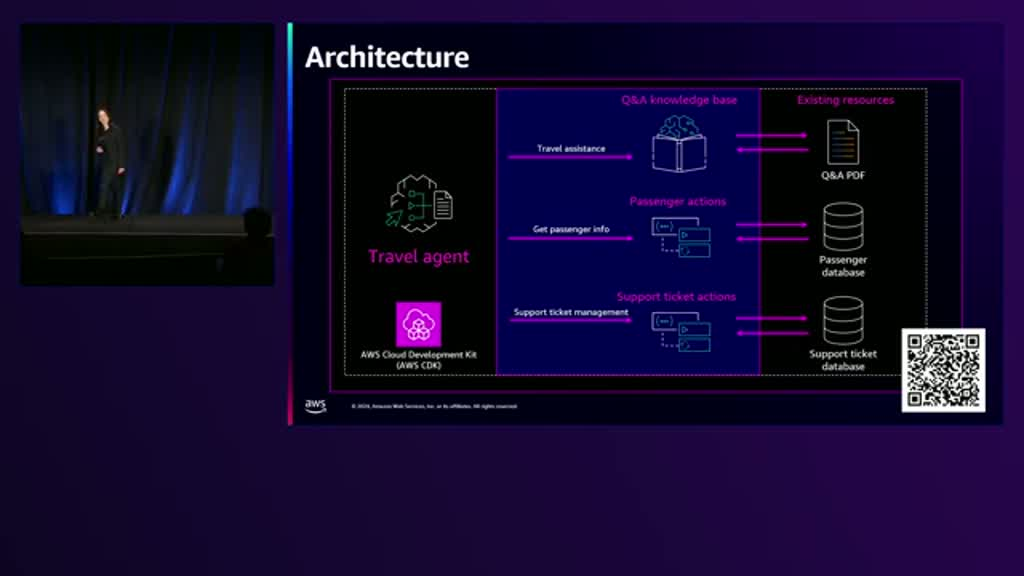

In [47]:
one_image = random.choice(files)
print(one_image)
display(PILImage.open(one_image))

Image:
./tmp/video/sec_01956.jpg
similarity:0.9807298790973514
metadata:{"second":1955}



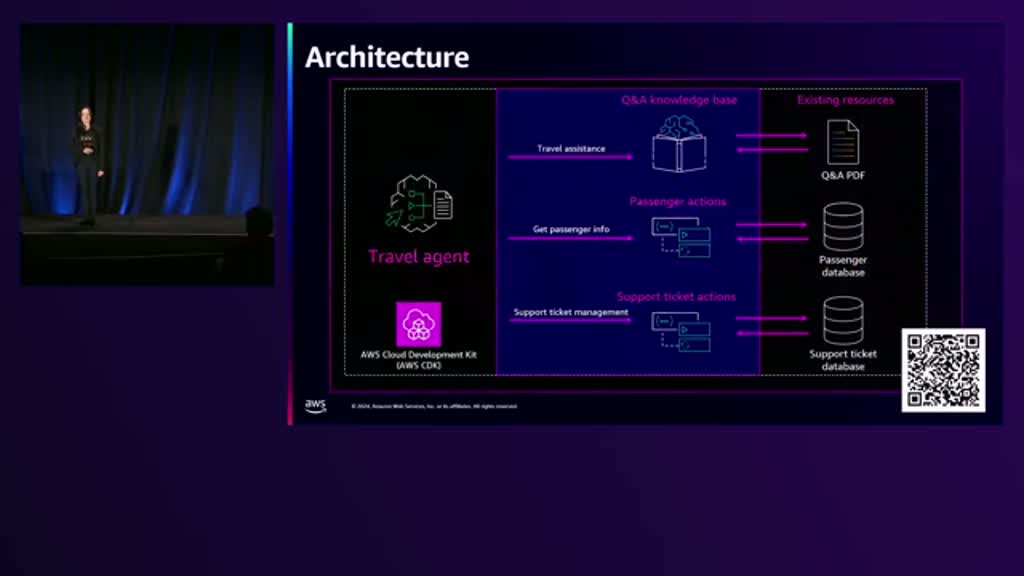

Image:
./tmp/video/sec_00220.jpg
similarity:0.8824123407129155
metadata:{"second":219}



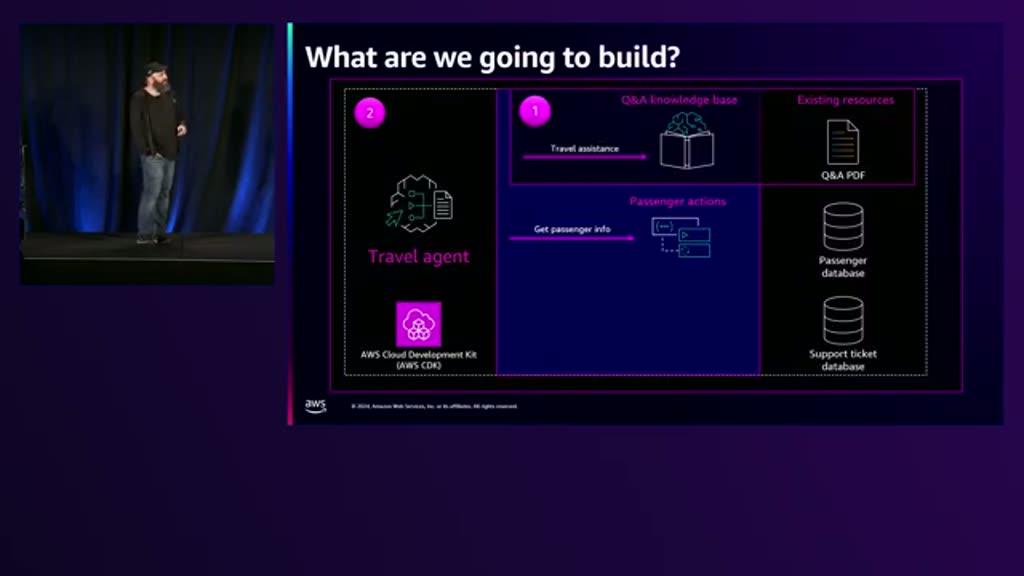

Image:
./tmp/video/sec_01820.jpg
similarity:0.7683054804801941
metadata:{"second":1819}



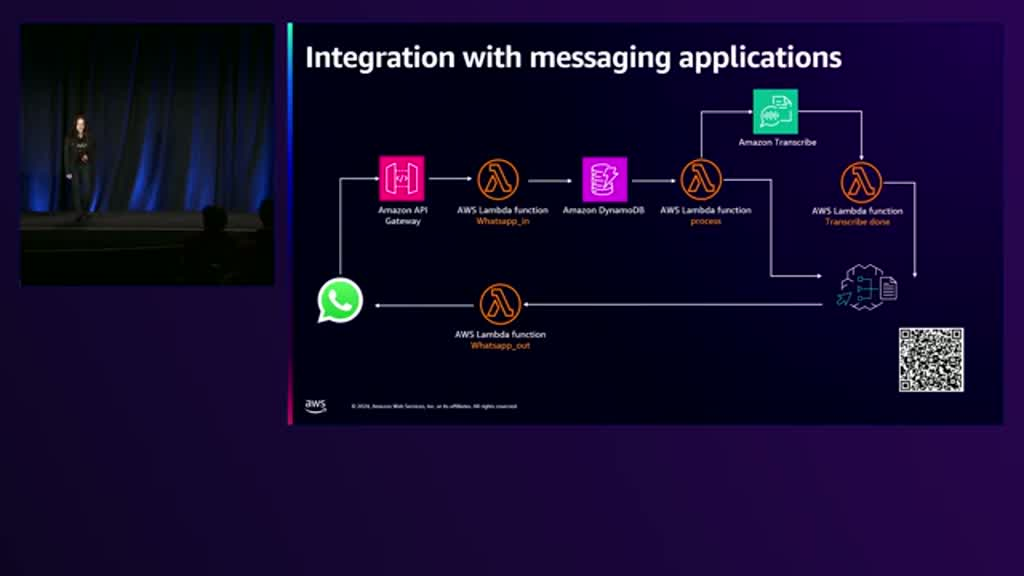

In [48]:
docs = retrieve(videomanager.read_image_from_local(one_image), how="cosine", k=3)

## RAG Implementation

Finally, the notebook implements a complete RAG system:
- `CustomMultimodalRetriever`: A custom retriever class that extends BaseRetriever
- `_get_relevant_documents()`: Core retrieval method that finds similar content
- `image_content_block()`: Formats image content for LLM consumption
- `text_content_block()`: Formats text content for LLM consumption
- `parse_docs_for_context()`: Processes documents for context (text and images)
- `ThinkingLLM`: Uses an LLM to answer questions based on retrieved content

> Based on https://github.com/langchain-ai/langchain/blob/master/docs/docs/how_to/custom_retriever.ipynb



In [43]:
from typing import List

from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever

class CustomMultimodalRetriever(BaseRetriever):
    """A retriever that contains the top k documents that contain the user query.
    query could be text or image_bytes
    """
    k: int
    """Number of top results to return"""
    how: str
    """How to calculate the similarity between the query and the documents."""

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        """Sync implementations for retriever."""
        search_vector = embedding_generation.get_embeddings(query)
        result = aurora.similarity_search(search_vector, how=self.how, k=self.k)
        rows = json.loads(result.get("formattedRecords"))

        matching_documents = []

        for row in rows:
            document_kwargs = dict(
                metadata=dict(**json.loads(row.get("metadata")), content_type = row.get("content_type"), source=row.get("sourceurl")))
            
            if self.how == "cosine":
                document_kwargs["similarity"] = row.get("similarity")
            elif self.how == "l2":
                document_kwargs["distance"] = row.get("distance")

            if row.get("content_type") == "text":
                matching_documents.append( Document( page_content=row.get("chunks"), **document_kwargs ))
            if row.get("content_type") == "image":
                matching_documents.append( Document( page_content=row.get("source"),**document_kwargs ))

        return matching_documents

In [44]:
retriever = CustomMultimodalRetriever(how="cosine", k=4)

In [55]:
list(docs)

[Document(metadata={'speaker': 'spk_0', 'second': 321, 'content_type': 'text', 'source': 'https://s3.us-east-1.amazonaws.com/embeddings-demo-1234-east-1/videos/video.mp4/transcribe.json'}, page_content="memory . A place where all the information is stored and can easily be retrievable , and that's where the vector database comes in . This is the the first building block . And a vector database stores and retrieves data in the form of vector embeddeds or mathematical representations . This allows us to find similarities between data rather than relying on the exact keyword match that is what usually happens up to today . This is essential for systems like retrieval ofmented generation or RAC , which combines external knowledge with the AI response to deliver those accurate and context aware response . And by the way , I think yesterday we announced the re-rank API for RAC . So now your rack applications , you can score and it will prioritize those documents that have the most accurate i

In [50]:
query = "vetor data base"
docs = retriever.invoke(query)


In [56]:
list(docs)

[Document(metadata={'speaker': 'spk_0', 'second': 321, 'content_type': 'text', 'source': 'https://s3.us-east-1.amazonaws.com/embeddings-demo-1234-east-1/videos/video.mp4/transcribe.json'}, page_content="memory . A place where all the information is stored and can easily be retrievable , and that's where the vector database comes in . This is the the first building block . And a vector database stores and retrieves data in the form of vector embeddeds or mathematical representations . This allows us to find similarities between data rather than relying on the exact keyword match that is what usually happens up to today . This is essential for systems like retrieval ofmented generation or RAC , which combines external knowledge with the AI response to deliver those accurate and context aware response . And by the way , I think yesterday we announced the re-rank API for RAC . So now your rack applications , you can score and it will prioritize those documents that have the most accurate i

# Building the RAG 

In [57]:
from typing import List, Dict
bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name=_region_name)


budget_tokens = 0
max_tokens = 1024
conversation: List[Dict] = []
reasoning_config = {"thinking": {"type": "enabled", "budget_tokens": budget_tokens}}

In [58]:
def image_content_block(image_file):
    image_bytes = videomanager.read_image_from_local(image_file)
    extension = image_file.split('.')[-1]
    print (f"Including Image :{image_file}")
    if extension == 'jpg':
        extension = 'jpeg'
    
    block = { "image": { "format": extension, "source": { "bytes": image_bytes}}}
    return block

def text_content_block(text):
    return { "text": text }

def parse_docs_for_context(docs):
    blocks = []
    for doc in docs:
        if doc.metadata.get('content_type') == "image":
            blocks.append(image_content_block(doc.page_content))
        else:
            blocks.append(text_content_block(doc.page_content))
    return blocks

In [ ]:
def answer(model_id,system_prompt,content) -> str:
    """Get completion from Claude model based on conversation history.

    Returns:
        str: Model completion text
    """

    # Invoke model
    kwargs = dict(
        modelId=model_id,
        inferenceConfig=dict(maxTokens=max_tokens),
        messages=[
            {
                "role": "user",
                "content": content,
            }
        ],

    )

    kwargs["system"] = [{"text": system_prompt}]

    response = bedrock_runtime.converse(**kwargs)
    
    return response.get("output",{}).get("message",{}).get("content", [])
    


In [59]:
parsed_docs = parse_docs_for_context(docs)

Including Image :./tmp/video/sec_00334.jpg
Including Image :./tmp/video/sec_00331.jpg


In [60]:

system_prompt = """Answer the user's questions based on the below context. If the context has an image, indicate that it can be reviewed for further feedback.
If the context doesn't contain any relevant information to the question, don't make something up and just say "I don't know". (IF YOU MAKE SOMETHING UP BY YOUR OWN YOU WILL BE FIRED). For each statement in your response provide a [n] where n is the document number that provides the response. """
model_id = "us.amazon.nova-pro-v1:0"


In [ ]:
query = "<your-query>"
docs = retriever.invoke(query)
parsed_docs = parse_docs_for_context(docs)

In [ ]:
llm_response = answer(model_id,system_prompt,[text_content_block(f"question:{query}\n\nDocs:\n"), *parsed_docs])

In [ ]:
print(llm_response[0].get("text"))

In [ ]:
query = "<your-query>"
docs = retriever.invoke(query)
parsed_docs = parse_docs_for_context(docs)
llm_response = answer(model_id,system_prompt,[text_content_block(f"question:{query}\n\nDocs:\n"), *parsed_docs])
print(llm_response[0].get("text"))